In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
pd.options.display.float_format = '{:20,.2f}'.format

## Load

In [3]:
connection = sqlite3.connect('airbnb.db')
cursor = connection.cursor()

In [4]:
vwListings = pd.read_sql_query("SELECT * from most_recent_listings", connection)

In [5]:
connection.close()

## Transform

In [6]:
def price_to_numeric(df):
    df['price'] = df['price'].str.replace(',','',regex=False)
    df['price'] = df['price'].str.strip('$').astype('float')

In [7]:
price_to_numeric(vwListings)

### ONLY FOR USE IN REGRESSION.IPYNB

In [ ]:
vwListings['room_type_mod'] = vwListings['room_type']
vwListings.loc[vwListings['property_type'].isin(['Room in hotel', 'Room in boutique hotel',
        'Private room in bed and breakfast']), 'room_type_mod'] = 'Hotel room'

## Drop

In [8]:
vwListings.drop(vwListings.loc[vwListings['price']==0].index, inplace=True)

In [9]:
vwListings.drop(vwListings.loc[vwListings['has_availability']=='f'].index, inplace=True)

In [10]:
vwListings['reviews_per_month'] = vwListings['reviews_per_month'].replace({'': 0})
vwListings.drop(vwListings.loc[vwListings['reviews_per_month'] > 31].index, inplace=True)

## Baseline Model

We would like to give our hosts recommendations on how to price their listing(s) on a given day. We want to recommend a price that is consistent with the prices of other listings. To make a recommendation, we predict the price based on past listing prices. 

We're indifferent between overestimates and underestimates. Both lead to decreased revenue for hosts, just in different ways: overestimates lead to fewer bookings, while underestimates leave money that could have been charged on the table. We'd also like to penalize large errors more than small errors. Therefore, we will use the mean as a null model since it minimizes Mean Squared Error.

We calculate the mean price in our sample:

In [11]:
price = vwListings['price']
price_predict = round(price.mean(),2)
price_predict

178.81

The Baseline Model predicts a price / day of $178.90.

To see if we can get an idea of the error bounds on this prediction, we calculate the standard deviation of price / day.

In [12]:
round(vwListings['price'].std(), 2)

205.54

Options:

- No error interval

- Something else more complicated?

## Distributional Model

In [13]:
from scipy.stats import norm, lognorm

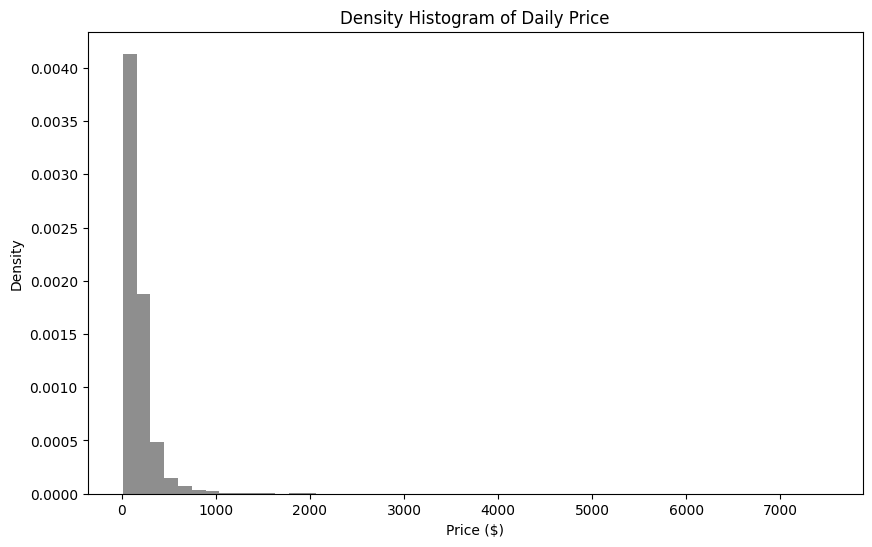

In [14]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(price, color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel( "Price ($)")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Daily Price")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

plt.show()
plt.close()

## Log-Normal Distribution

Used for multiplicative as opposed to additive effects.

It makes sense that the variables would have a multiplicative effect on the price. For instance:

<ol>
    <li>Each extra bedroom increases the price by 20%.</li>
    <li>Each extra bedroom increases the price by $50.</li>
</ol>

Option 1 makes more sense. An extra bedroom in a nice neighborhood is going to be worth more in absolute terms than an extra bedroom in a bad neighborhood.

In [15]:
m1 = price.mean()
m2 = price.var()

x_bar = np.log(m1**2/(np.sqrt(m2 + m1**2)))
s_2 = np.log(1 + m2/m1**2)
x_bar, s_2

(4.76525721782578, 0.8421503986699735)

In [16]:
m1 = np.log(price).mean()
m2 = np.log(price).var()

x_bar = m1
s_2 = m2

x_bar, s_2

(4.916961086869932, 0.4743924454495844)

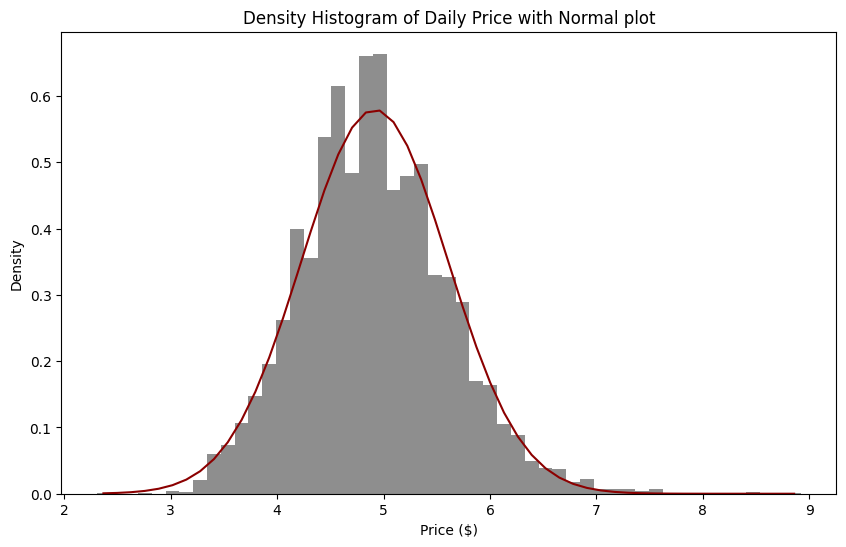

In [17]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(np.log(price), color="DimGray", density=True, bins=51, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of Daily Price with Normal plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [norm.pdf(k, loc=x_bar, scale=np.sqrt(s_2)) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

In [18]:
log_price = np.log(price)

mu = log_price.mean()
sigma = log_price.std()

mu, sigma

(4.916961086869932, 0.6887615301754189)

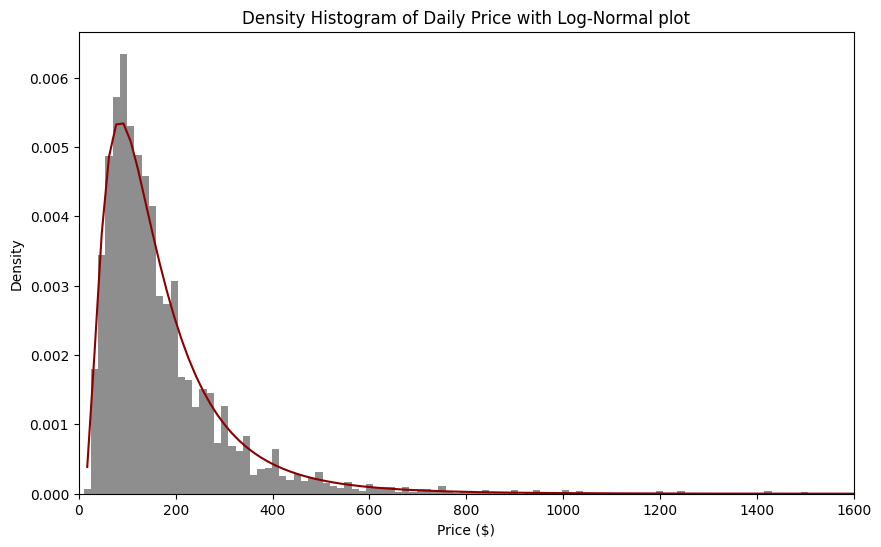

In [19]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(price, color="DimGray", density=True, bins=501, alpha=0.75)
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of Daily Price with Log-Normal plot")

axes.set_xlim(0,1600)

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [lognorm.pdf(k, s=sigma, loc=0, scale=np.exp(mu)) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

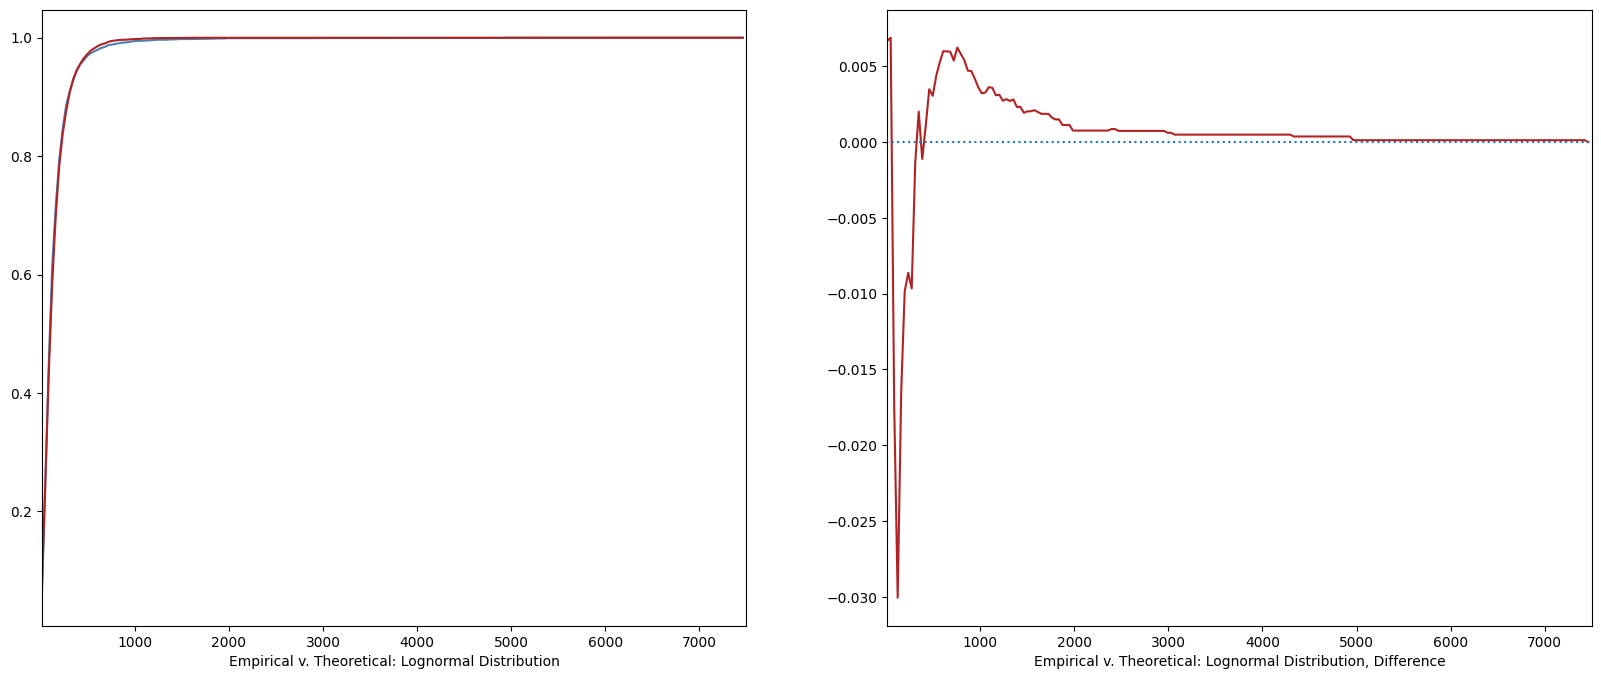

In [20]:
figure = plt.figure(figsize=(20, 8))

price_mn = np.min(price)
price_mx = np.max(price)
mean = np.mean(price)
std = np.std(price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(price, bins=201, density=True)
cumulative = np.cumsum(values*(base[1:] - base[:-1]))
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((price_mn, price_mx))

values2, base2 = np.histogram(lognorm.rvs(s=sigma, loc=0, scale=np.exp(mu), size=10000), bins=base, density=True)
cumulative2 = np.cumsum(values2*(base2[1:] - base2[:-1]))
axes.plot(base[:-1], cumulative2, color="firebrick")
axes.set_xlim((price_mn, price_mx))
axes.set_xlabel("Empirical v. Theoretical: Lognormal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((price_mn, price_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel("Empirical v. Theoretical: Lognormal Distribution, Difference")

plt.show()
plt.close()